In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import glob

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split

In [2]:
class EarlyStoppingAt(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        if logs.get(self.monitor) <= self.value:
            self.model.stop_training = True

In [3]:
allFiles = glob.glob('data/*.csv')
allFiles

['data\\Challenger_Ranked_Games.csv',
 'data\\GrandMaster_Ranked_Games.csv',
 'data\\Master_Ranked_Games.csv']

In [4]:
df = pd.DataFrame([])
for _ in allFiles:
    dfs = pd.read_csv(_)
    dfs['rank'] = _[5:-17]
    df = pd.concat([df,dfs])

df = df.reset_index(drop=True)
df['rank'] = np.where(df['rank']=='Master',0,df['rank'])
df['rank'] = np.where(df['rank']=='GrandMaster',1,df['rank'])
df['rank'] = np.where(df['rank']=='Challenger',2,df['rank'])
df['rank'] = df['rank'].astype('int64')
df = df.drop(columns={'redWins','gameId'}) #----- mirror of output
df = df.astype('int64')

    dfx = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    dfx_scaled = min_max_scaler.fit_transform(dfx)
    df = pd.DataFrame(dfx_scaled,columns=df.columns)

In [5]:
target = 'blueWins'

X = df.drop(columns={target})
y = df[target]

In [6]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=420)

X_train = X_train.reset_index(drop=True).values.reshape(-1,48,1,1)
X_test = X_test.reset_index(drop=True).values.reshape(-1,48,1,1)

In [7]:
input_ = tf.keras.Input((48, 1, 1))
fl = tf.keras.layers.Flatten()(input_)

dense1 = tf.keras.layers.Dense(100, activation='relu')(fl)
dense2 = tf.keras.layers.Dense(80, activation='relu')(dense1)
output = tf.keras.layers.Dense(2, activation='softmax')(dense2) #---------------- softmax returns normalized prediction values | sums to 1


model = tf.keras.Model(inputs=input_, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 1, 1)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               4900      
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 162       
Total params: 13,142
Trainable params: 13,142
Non-trainable params: 0
_________________________________________________________________


In [8]:
#filepath = r'models/'
bestFilePath = r'models/best_model/'

cbList = [
    EarlyStoppingAt(monitor='val_loss', value=0.01),
    tf.keras.callbacks.ModelCheckpoint(bestFilePath, save_best_only=True)
         ]

In [9]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
hst = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=cbList)

Train on 159940 samples, validate on 39985 samples
Epoch 1/10
158784/159940 [============================>.] - ETA: 0s - loss: 47.9307 - accuracy: 0.9551WARNING:tensorflow:From C:\Users\Alec\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/best_model/assets
159940/159940 [==============================] - 13s 82us/sample - loss: 47.6471 - accuracy: 0.9552 - val_loss: 9.5063 - val_accuracy: 0.9635
Epoch 2/10
159940/159940 [==============================] - 10s 63us/sample - loss: 4.2049 - accuracy: 0.9621 - val_loss: 0.8981 - val_accuracy: 0.9582
Epoch 3/10
159940/159940 [==============================] - 10s 65us/sample - loss: 0.3078 - accuracy: 0.9492 - val_loss: 0.1323

In [11]:
best_model = tf.keras.models.load_model(bestFilePath)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

In [12]:
print('Random Guess Accuracy: 50%')
print('Model Accuracy: ', "%.4f" % (accuracy_score(y_test, y_test_pred) * 100), '%')

Random Guess Accuracy: 50%
Model Accuracy:  97.4290 %


In [13]:
print('Model Precision: ', "%.4f" % (precision_score(y_test, y_test_pred) * 100), '%')

Model Precision:  98.3770 %


In [14]:
print('Model Recall: ', "%.4f" % (recall_score(y_test, y_test_pred) * 100), '%')

Model Recall:  96.4001 %


In [15]:
print('Model Precision, and Recall: \n')
print(classification_report(y_test, y_test_pred))

Model Precision, and Recall: 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     20179
           1       0.98      0.96      0.97     19806

    accuracy                           0.97     39985
   macro avg       0.97      0.97      0.97     39985
weighted avg       0.97      0.97      0.97     39985



Confusion Matrix: 



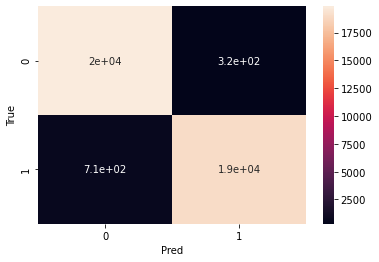

In [16]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)
plt.ylabel('True')
plt.xlabel('Pred')
print('Confusion Matrix: \n')
plt.show()